# End-to-end quantum chemistry VQE using Qu & Co Chemistry
In this tutorial we show how to solve the groundstate energy of a hydrogen molecule using VQE, as a function of the spacing between the atoms of the molecule. For a more detailed discussion on MolecularData generation or VQE settings, please refer to our other tutorials. We here focus on the exact UCCSD method, which is the upper bound of a UCCSD-based VQE approach performance. In reality, errors are incurred by Trotterizing the UCC Hamiltonian evolution.

In [1]:
from openfermion.hamiltonians import MolecularData
from qucochemistry.vqe import VQEexperiment
from openfermionpyscf import run_pyscf
import numpy as np

#H2 spacing
spacing =np.array([0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.74,0.75,0.8,0.85,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.2,2.4,2.6,2.8,3.0])
M=len(spacing)

# Set molecule parameters and desired basis.
basis = 'sto-3g'
multiplicity = 1

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 1
run_ccsd = 1
run_fci = 1

E_fci=np.zeros([M,1])
E_hf=np.zeros([M,1])
E_ccsd=np.zeros([M,1])
E_uccsd=np.zeros([M,1])
E_uccsd_opt=np.zeros([M,1])

for i, space in enumerate(spacing):
    #construct molecule data storage object 
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., space))]
    molecule = MolecularData(geometry, basis, multiplicity,description='pyscf_H2_' + str(space*100))

    molecule.filename = 'molecules/H2/H2_pyscf_' + str(space)[0] +'_' +str(space)[2:] #location of the .hdf5 file to store the data in

    # Run PySCF to add the data.
    molecule = run_pyscf(molecule,
                        run_scf=run_scf,
                        run_mp2=run_mp2,
                        run_cisd=run_cisd,
                        run_ccsd=run_ccsd,
                        run_fci=run_fci)
    
    vqe = VQEexperiment(molecule=molecule,method='linalg', strategy='UCCSD')
    
    E_uccsd[i]=vqe.objective_function()
    
    vqe.start_vqe()
    
    E_uccsd_opt[i]=vqe.get_results().fun
    
    E_fci[i]=float(molecule.fci_energy)
    E_hf[i]=float(molecule.hf_energy)
    E_ccsd[i]=float(molecule.ccsd_energy)

We compare the results for 5 different strategies: classical HF, CCSD, and FCI, with a quantum unitary variant of CCSD, called UCCSD and its optimized version. In other words, we calculate the Hamiltonian expectation value for a wavefunction which was propagated by a UCCSD ansatz with CCSD amplitudes. Then we initiate an optimization algorithm over these starting amplitudes in order to reach even closer to the true ground state and thus minimizing the energy.

In essence, with the method='linalg' option, we do not create a quantum circuit, but rather directly take the matrix exponential of the UCC-Hamiltonian. In reality, for a gate-based architecture, one would need to select a Trotterization protocol to execute this action on a QPU, incurring Trotterization errors along the way. 

We plot the results below:

<IPython.core.display.Javascript object>


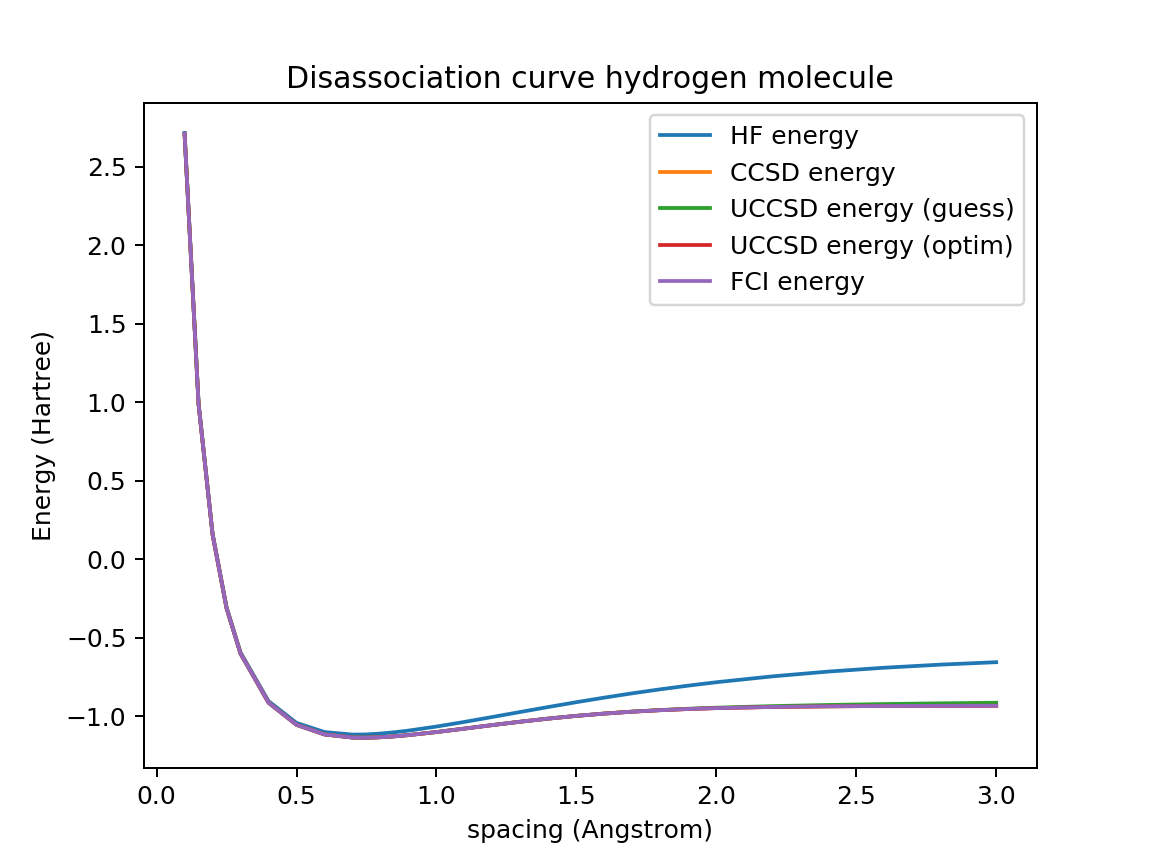

In [2]:
%matplotlib notebook

import matplotlib.pyplot as plt

plt.figure()
plt.plot(spacing,E_hf,label='HF energy')
plt.plot(spacing,E_ccsd,label='CCSD energy')
plt.plot(spacing,E_uccsd,label='UCCSD energy (guess)')
plt.plot(spacing,E_uccsd_opt,label='UCCSD energy (optim)')
plt.plot(spacing,E_fci,label='FCI energy')
plt.xlabel('spacing (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Disassociation curve hydrogen molecule')
plt.legend()

<IPython.core.display.Javascript object>


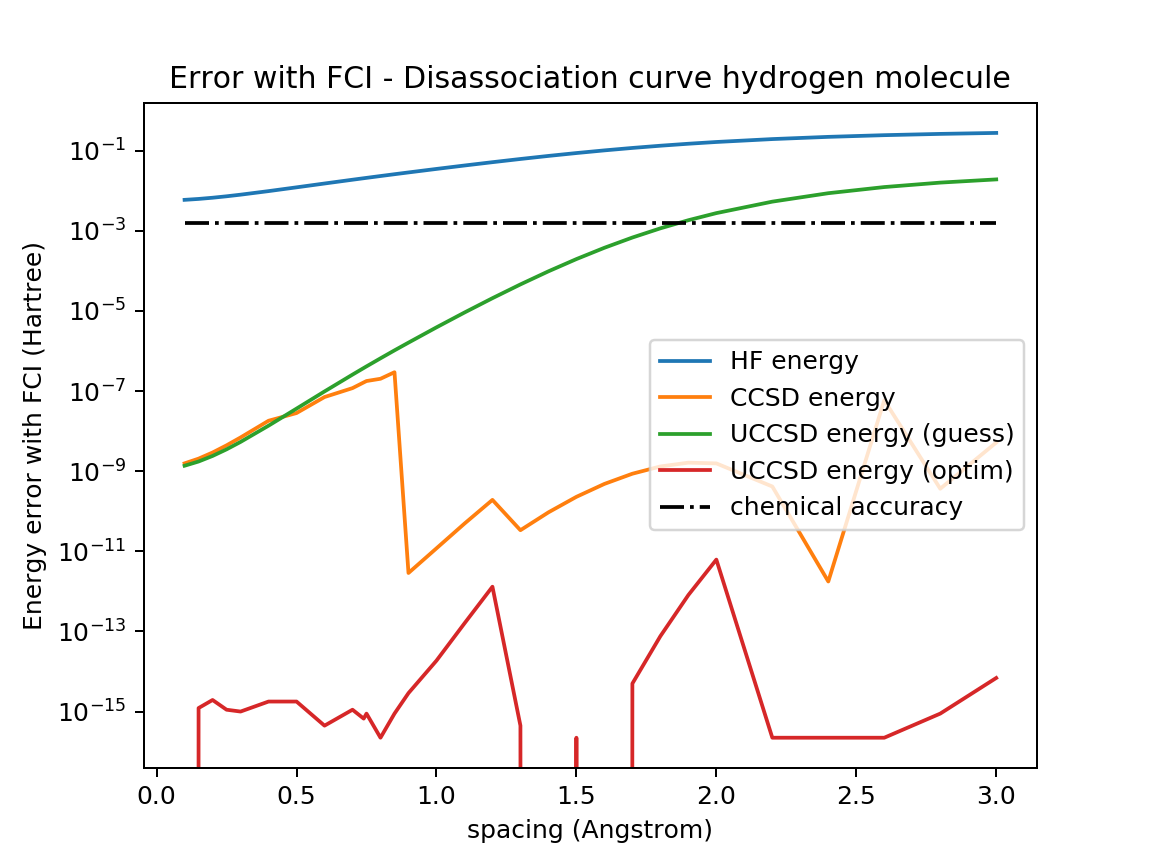

In [3]:
plt.figure()
plt.semilogy(spacing,np.abs(E_fci-E_hf),label='HF energy')
plt.semilogy(spacing,np.abs(E_fci-E_ccsd),label='CCSD energy')
plt.semilogy(spacing,np.abs(E_fci-E_uccsd),label='UCCSD energy (guess)')
plt.semilogy(spacing,np.abs(E_fci-E_uccsd_opt),label='UCCSD energy (optim)')
plt.semilogy(spacing,0.0016*np.ones([len(spacing),1]),label='chemical accuracy',linestyle='-.',color='black')
plt.xlabel('spacing (Angstrom)')
plt.ylabel('Energy error with FCI (Hartree)')
plt.title('Error with FCI - Disassociation curve hydrogen molecule')
plt.legend()

We find that the HF energy is not within chemical accuracy with the FCI energy, while CCSD and UCCSD can reach that level. Clearly, for larger bond distances the approximations are less accurate but still the UCCSD optimization reaches numerical precision accuracy to the ground state. Note that the UCCSD method is not guaranteed to reach this level of accuracy with general molecules; one can experiment with that using this notebook before implementing the UCC in a quantum circuit, which will always perform worse.